code accompanying P Selvakumar and R Siddharthan, "Position-specific evolution in transcription factor binding
  sites, and a fast likelihood calculation for the F81 model"
  
tested with Julia 1.9.1

In [1]:
using NLopt
using Logomaker

#### NodeData contains the data for the node: 
`label` comes from the Newick string
`labelnum` is created by the function `set_labelnums!` and is a unique positive number corresponding to each leaf (internal nodes have `labelnum` 0
`q` is proximity of node to its parent ($q = \exp (-\mu t)$ where $\mu$ is mutation rate and $t$ is evolutionary time)

In [2]:
mutable struct NodeData
    label::String
    labelnum::Int64 # for efficiency, encode labels by unique numbers
    q::Float64
end

In [3]:
mutable struct Node
    data::NodeData
    children::Vector{Union{Nothing,Node}}
    function Node(data)
        new(data,[])
    end
end

code to convert Newick strings to trees and vice versa

In [4]:
function split_string_by_bracket(s)
    splitlist = []
    substr = ""
    nleft = 0
    nright = 0
    for c in s
        if c == '('
            nleft += 1
        elseif c == ')'
            nright += 1
        end
        if c==',' && nleft==nright
            push!(splitlist,substr)
            substr = ""
        else
            substr *= c
        end
    end
    push!(splitlist, substr)
    return splitlist
end
        
function newick_to_tree(s::String)
    if s[end] == ';'    # full tree
        if s[end-1]==')'  # no root height
            height = 0.0
        else
            height = parse(Float64,split(s,":")[end][1:end-1])
              # the thing after ":" and before ;
        end
    else
        height = parse(Float64,split(s,":")[end]) # no ; for internal nodes
    end
    tree = Node(NodeData("",0,height))
    if s[1]=='(' # find closing brace
        last = length(s)
        try
            while s[last]!= ')'
                last -= 1
            end
        catch
            println(s)
            throw(ArgumentError)
        end
        children = split_string_by_bracket(s[2:last-1])
        tree.children = [newick_to_tree(c) for c in children]
    else # leaf
        label = split(s,":")[1]
        tree.data = NodeData(label,0,tree.data.q)
    end
    return tree
end
            

newick_to_tree (generic function with 1 method)

In [5]:
function tree_to_newick(t::Node, depth::Int64=0)
    if depth==0
        endtoken = ";"
    else
        endtoken = ""
    end
    if t.children == []
        return t.data.label*":"*string(t.data.q)*endtoken
    else
        return "("*join([tree_to_newick(c,depth+1) for c in t.children],",")*"):"*string(t.data.q)*endtoken
    end
end

tree_to_newick (generic function with 2 methods)

Get all leaves below a node, by depth first search

In [6]:
function get_leaves(t::Node)
    if t.children==[]
        return [t.data]
    else
        return reduce(vcat,[get_leaves(c) for c in t.children])
    end
end

get_leaves (generic function with 1 method)

In [7]:
function get_internal_nodes(t::Node)
    if t.children==[]
        return NodeData[]
    else
        return reduce(vcat,[t.data; [get_internal_nodes(c) for c in t.children]])
    end
end

get_internal_nodes (generic function with 1 method)

set labelnums to a tree, remember to do this before calling any other routines
(to ensure it, below is a wrapper function that also calls newick_to_tree)

unique numbers are attached, first to leaves, then to internal nodes

In [8]:
function set_labelnums!(t::Node)
    leaves = get_leaves(t)
    inodes = get_internal_nodes(t)
    nl = length(leaves)
    nin = length(inodes)
    for n in 1:nl+nin
        if n <= nl
            leaves[n].labelnum = n
        else
            inodes[n-nl].labelnum = n
        end
    end
    return [l.label for l in leaves]
end

# returns a tree, as well as a list of leaves in the same order as labelnum
function treeFromNewick(s::String)
    t = newick_to_tree(s)
    leaves = set_labelnums!(t)
    return t,leaves
end

treeFromNewick (generic function with 1 method)

### maybe not needed; remove?

In [9]:
function set_qlist_all!(tree::Node,q::Float64)
    tree.data.q = q
    for c in tree.children
        c.data.q = q
        set_qlist_all!(c,q)
    end
end

set_qlist_all! (generic function with 1 method)

### TFBS evolution:

1. take collection of neutral sites, learn the $q$'s   
   * requires a tree with fixed topology. Then fit the $q$'s as in the methods
2. take Felsenstein $T$ using these $q$'s and a $\vec{\pi}$ to be learned
3. maximum-likelihood estimation of $\vec{\pi}$ per position in TFBS 

### Learning the maximum likelihood $q$ values for a collection of neutral sites

1. convert $q$'s to a vector for use in `optimize` (from `NLopt` package)
2. if tree has $N$ nodes, there are $N-2$ $q$'s for binary tree, because root node has no height, and 
we can assume one of the children (right child) has no height ($q=1$).  
2a. if root has more than 2 children, we need to assign $q$ for each child.
3. function to be minimized = Felsenstein likelihood for leaves as a function of $q$'s and fixed tree topology.

### Fast calculation of likelihood for Felsenstein F81 model

In general the Felsenstein algorithm for likelihood is slow. But for the F81 model ($T_{\beta\alpha;q} = q\delta_{\alpha\beta} + (1-q) \pi_\beta$) there is a shortcut: the likelihood can be written as a sum of star topologies, as follows. So reduce a tree to a sum of star-topology trees and carry out.

Suppose the root node has children which all have star topologies. The likelihood is
$$ L = \sum_\alpha \pi_\alpha \sum_{\beta, \gamma, \ldots} T_{\beta\alpha} T_{\gamma\alpha} \ldots$$
Take the $T_{\beta\alpha}$ factor and suppose all children of the $\beta$ node are leaves. Putting in
$$T_{\beta\alpha} = q \delta{\alpha\beta} + (1-q) \pi_\beta$$ we get
$$ L = \sum_\alpha \pi_\alpha \sum_\beta (q\delta_{\alpha\beta} + (1-q)\pi_\beta) \ldots \sum_{\gamma\delta\ldots} T_{\gamma\alpha}\ldots$$
Essentially, if a child has star topology, with weight $q$ you attach its leaves to the parent, and with weight $1-q$ you make it a separate tree that multiplies the original tree. 
Recursion:
1. Initialize a list of lists ${[T]}$ , initially with a single tree list with a single element $[T]$
2. For each $[T]$ 
   - The first element is the relevant one, the rest are multipliers
   - While $T$ has non-star nodes
     * identify a star node in $T$ (first element of list only)
     * break $T$ into two pieces: "merged" (where star node leaves are merged into parent) and "pruned" (where star node leaves are removed, and turned into overall multiplier for remainder of tree)
     * remove any single-child nodes in tree 
     * all other multipliers remain, i.e. eg 
     
     `[[T]] ->` 
     
     `[[T'],[T'',Tm1]] -> `
     
     `[[T'],[T''', Tm1],[T'''',Tm1, Tm2]]`
     
     etc.
     
     Basically, split the first tree in the list; make two new lists, one with the merged tree and      previous multipliers; the other with the pruned tree and previous multipliers as well as new multiplier.
     
   - weight of tree = $q$ in its root 

In [10]:
is_star(t::Node) = (t.children != []) && all(map(x->x.children==[],t.children))

is_leaf(t::Node) = t.children==[]

is_leaf (generic function with 1 method)

`rebalance!` rearranges a tree such that
* for any node, all children that are leaves are to the right
* any node with a single child is merged with its parent

In [11]:
function rebalance!(t::Node, isroot=false) # ensure leaves are on right
    # also ensure no nodes with only one child
    if all(map(is_leaf, t.children))
        return
    elseif isroot && length(t.children)==1 # merge with root
        t.data.q *= t.children[1].data.q
        t.children = t.children[1].children
        rebalance!.(t.children)
        return
    else
        children1 = filter(!is_leaf, t.children)
        children2 = filter(is_leaf, t.children)
        children1a = Node[]
        for c in children1 
            while length(c.children)==1 # if child has only one child, merge with parent
                c1 = c.children[1]
                c1.data.q = c1.data.q * c.data.q
                c = c1
            end
            if is_leaf(c)
                push!(children2,c)
            else
                push!(children1a,c)
            end

        end
        t.children = vcat(children1a,children2)        
        rebalance!.(children1a)
        return
    end
end

rebalance! (generic function with 2 methods)

In [12]:
function printTlist(tlist)
    for tl in tlist
        for n = 1:length(tl)
            println(" "^n, tree_to_newick(tl[n]))
        end
    end
end

printTlist (generic function with 1 method)

In [13]:
# assume t is "balanced" with all leaves to the right?
function remove_star!(t::Node)
    # t_merged = t, modify in-place
    tp = deepcopy(t) # eventual pruned tree
    parent = t
    parentp = tp
    node1 = t.children[1]
    node1p = tp.children[1]
    while ! is_star(node1)
        parent = node1
        node1 = node1.children[1]
        parentp = node1p
        node1p = node1p.children[1]
    end
    filter!(c->c≠node1, parent.children)
    filter!(c->c≠node1p, parentp.children)
    # attach node1's children to parent, return node1p, caller can figure out what to do with q
    for c in node1.children
        push!(parent.children,c)
    end
    return tp, node1p
end

function reduce_trees_to_stars(t::Node)
    tlist = Vector{Node}[[deepcopy(t)]]
    while ! all(map(is_star, [t[1] for t in tlist]))
        #println("-----")
        #printTlist(tlist)
        for t in tlist
            rebalance!(t[1],true)
        end    
        i = 1
        while is_star(tlist[i][1])
            i += 1
        end
        tl1 = tlist[i]
        tp, node1p = remove_star!(tl1[1])
        # now the original node tl1[1] has star leaves merged with parent
        # tp, node1p are pruned tree and the removed star tree
        tl1[1].data.q *= node1p.data.q
        node1p.data.q = 1-node1p.data.q 
        newlist = [tp]
        for x in tl1[2:end]
            push!(newlist,x)
        end
        push!(newlist,node1p)
        push!(tlist,newlist)

    end
    for t in tlist
        rebalance!(t[1],true)
    end    
    return tlist                
end

reduce_trees_to_stars (generic function with 1 method)

### Felsenstein likelihood calculation

Note convention

A=1, C=2, G=3, T=4 because of Julia's 1-indexing

In [14]:
function felsS(a::Int64,b::Int64,q::Float64,statprob::Vector{Float64}=[0.25,0.25,0.25,0.25])
    # a, b are 1,2,3,4 == A, C, G, T
    # q is proximity
    # statprob = stationary probability distribution
    # this is prob of ancestor b mutating to descendant a
    f = (1.0-q)*statprob[a]
    if a==b
        f += q
    end
    return f
end

felsS (generic function with 2 methods)

### Needed only for the full felsenstein algorithm which assumes binary tree

Retained only as a sanity check

In [15]:
# call this on a deepcopy not original tree!
function binarize_tree(t2::Node)
    if is_leaf(t2)
        return
    else # t2.children are > 2, assume not 1
        rebalance!(t2)
        if length(t2.children)>2
            newchildren = Node[]
            for n=2:length(t2.children)
                c = pop!(t2.children)
                push!(newchildren,c)
            end
            newnode = Node(NodeData("",0,1.0))
            newnode.children = newchildren
            push!(t2.children,newnode)
        end
        for c in t2.children
            binarize_tree(c)
        end
    end
end
        
        

binarize_tree (generic function with 1 method)

##### Felsenstein algorithm for likelihood

Purely as sanity check. Use `likelihood_star` etc for real work if using F81 model.

Assumes binary tree. Call `binarize_tree` on a copy of the tree first. 



###### improve speed by caching previous lookup results in a dict

In [16]:
function likelihood_one(node::Node,sites::Array{Int64,2},sitepos::Int64,a::Int64, 
        ll_dict::Dict{Tuple{Int64, Int64, Vector{Int64}}, Float64}, statprob::Vector{Float64})
    # likelihood of leaves below node given node value is a: Felsenstein's algorithm
    # assume binary tree
    if node.children == [] # leaf
        if sites[node.data.labelnum,sitepos]==a
            return 1.0
        else
            return 0.0
        end
    elseif length(node.children)==1 # single leaf case, should occur only with root node
        return statprob[node.children[1].data.labelnum]
    else
        key1 = (node.data.labelnum, a, [sites[l.labelnum,sitepos] for l in get_leaves(node)])
        #println(key1, node.data, ll_dict)
        if haskey(ll_dict,key1)
            return ll_dict[key1]
        else
            lik = 0.0
            left = node.children[1]
            right = node.children[2]
            for b in 1:4
                for c in 1:4
                    lik += felsS(b,a,left.data.q)*likelihood_one(left,sites,sitepos,b,ll_dict,statprob) *
                    felsS(c,a,right.data.q)*likelihood_one(right,sites,sitepos,c,ll_dict,statprob)
                end
            end
            ll_dict[key1] = lik
            return lik
        end
    end
end

function likelihood_all(root::Node, sites::Array{Int64,2}, sitelen::Int64, bgprob=[0.25,0.25,0.25,0.25])
    lik = 0.0
    ll_dict = Dict{Tuple{Int64,Int64, Vector{Int64}},Float64}()
    for i in 1:sitelen
        lik1 = 0.0
        for a in 1:4
            lik1 += likelihood_one(root,sites,i,a,ll_dict,bgprob)*bgprob[a]
        end
        lik += log(lik1)
    end
    return lik
end

likelihood_all (generic function with 2 methods)

##### Fast calculation of tree likelihood by first reducing it to sum of stars

In [17]:
# likelihood of node with star topology, ie only leaves as children
function likelihood_star_one(root::Node, sites::Array{Int64,2},sitepos::Int64,
        bgprob::Vector{Float64}=[0.25,0.25,0.25,0.25])
    lik = 0.0
    for α = 1:4 # root nucleotide
        lik1 = bgprob[α]
        for c in root.children
            lik1 *= felsS(sites[c.data.labelnum,sitepos],α,c.data.q,bgprob)
        end
        lik += lik1
    end
    return lik
end

likelihood_star_one (generic function with 2 methods)

In [18]:
function likelihood_all_stars(tlist::Vector{Vector{Node}},sites::Array{Int64,2},
    sitelen::Int64, bgprob::Vector{Float64}=[0.25,0.25,0.25,0.25])
    lik = 0.0
    for i = 1:sitelen
        lik0 = 0.0
        for t1 in tlist
            lik1 = 1.0
            for t in t1
                lik1 *= t.data.q*likelihood_star_one(t,sites,i,bgprob)
            end
            lik0 += lik1
        end
        lik += log(lik0)
    end
    return lik
end

likelihood_all_stars (generic function with 2 methods)

wrapper function for `likelihood_all_stars` so that you can directly call on a tree

In [19]:
function likelihood_all_fast(t::Node,sites::Array{Int64,2},sitelen::Int64,
    bgprob::Vector{Float64}=[0.25,0.25,0.25,0.25])
    tlist = reduce_trees_to_stars(t)
    return likelihood_all_stars(tlist,sites,sitelen,bgprob)
end

likelihood_all_fast (generic function with 2 methods)

#### Learning optimal $q$ from a collection of sites

Optimize the likelihood function as a function of $q$. 

For this, we need to be able to get a list of current $q$'s from the tree, as well as set them to the tree. 

If root of tree is binary, for $N$ nodes we have $N-2$ $q$-values. Else, $N-1$ q-values. (Root node has $q$=1.0 and, for binary tree, the two leaves aren't uniquely determined so we set the right leaf to have $q$=1.0)

`get_nodelist` gets the list of nodes, `get_qlist` gets the `q` values from these nodes, `set_qlist` sets `q` values for these nodes. All these apply to the full tree, not the one reduced to stars. 

##### For now: assume the full tree is binary or at least its root is binary. 

In [20]:
function get_nodelist(tree::Node,isroot::Bool,isrootright::Bool)::Vector{Node}
    if tree.children == []
        if isrootright
            return Node[]
        else
            return Node[tree]
        end
    else
        nodelist = reduce(vcat,[get_nodelist(c,false,false) for c in tree.children[1:end-1]])
        if isroot # root and its right child have no proximity ## FIXME this assumes root has 2 children
            nodelist = Node[nodelist; get_nodelist(tree.children[end],false,true)]
        elseif isrootright # the right child of the root node has q=1
            nodelist = Node[nodelist; get_nodelist(tree.children[end],false,false)]
        else
            nodelist = Node[nodelist;[tree];get_nodelist(tree.children[end],false,false)]
        end
        return nodelist
    end
end

function get_qlist(tree::Node)
    nodelist = get_nodelist(tree,true,false)
    return [n.data.q for n in nodelist]
end
    
function set_qlist!(tree::Node,qlist::Vector{Float64})
    tree.data.q = 1.0
    tree.children[end].data.q = 1.0
    nodelist = get_nodelist(tree,true,false)
    for i = 1:length(nodelist)
        nodelist[i].data.q = qlist[i]
    end
end
    

set_qlist! (generic function with 1 method)

In [21]:
function q_lik_func(q::Vector{Float64},tree::Node,sites::Array{Int64,2},sitelen::Int64,
        bgprob::Vector{Float64}=[0.25,0.25,0.25,0.25])
    set_qlist!(tree,q)
    lik = likelihood_all_fast(tree,sites,sitelen,bgprob)
    return -lik # minimize negative log-likelihood
end


q_lik_func (generic function with 2 methods)

In [22]:
function get_NLopt_qlist(t::Node,sites::Array{Int64,2},
        sitelen::Int64=0,bgprob::Vector{Float64}=[0.25,0.25,0.25,0.25])
    if sitelen==0
        sitelen = length(sites[1,:])
    end
    qlik(qlist,grad=[]) = q_lik_func(qlist,t,sites,sitelen,bgprob)
    qlist = get_qlist(t)
    opt = Opt(:LN_SBPLX,length(qlist))  # SBPLX seems to be recommended by NLopt maintainer
    # opt = Opt(:LN_NELDERMEAD,length(qlist))
    
    opt.min_objective = qlik
    opt.ftol_rel = 1e-10
    opt.lower_bounds = [1e-20 for q in qlist]
    opt.upper_bounds = [1-1e-20 for q in qlist]
    (optf,optx,ret) = NLopt.optimize(opt,qlist)
    return (optf,optx,ret)
end

get_NLopt_qlist (generic function with 3 methods)

#####  Fit $\pi$ vector with fixed $q$s

as input to this, `sites` is a matrix containing the collection of position-specific sites you are interested in, across all instances. 

In [23]:
function p_lik_func(p::Vector{Float64}, tree::Node,sites::Array{Int64,2},
        sitelen::Int64)
    if sum(p) > 1.0
        return 1e50 # infinity? crude bounds check
    else
        lik = likelihood_all_fast(tree,sites,sitelen,[p; 1.0-sum(p)])
        return -lik
    end
end

p_lik_func (generic function with 1 method)

In [24]:
function get_NLopt_pivec(t::Node,sites::Array{Int64,2},
        sitelen::Int64=0,bgprob::Vector{Float64}=[0.25,0.25,0.25,0.25])
    if sitelen==0
        sitelen = length(sites[1,:])
    end
    pilik(x,grad=[]) = p_lik_func(x,t,sites,sitelen)
    pilist = copy(bgprob[1:3])

    opt = Opt(:LN_SBPLX,3)  # SBPLX seems to be recommended by NLopt maintainer
    # opt = Opt(:LN_NELDERMEAD,4)
    #opt = Opt(:LN_COBYLA, 3)
    #opt = Opt(:LD_SLSQP, 3)
    #simplexconstraint2(x::Vector{Float64},g,a,b) = x[1] + x[2] + x[3] - 1.0
    opt.min_objective = pilik
    opt.ftol_rel = 1e-10
    opt.lower_bounds = [1e-20 for p in pilist]
    opt.upper_bounds = [1-1e-20 for p in pilist]
    #inequality_constraint!(opt, (x,g) -> simplexconstraint2(x,g,0,0), 1e-10)

    (optf,optx,ret) = NLopt.optimize(opt,pilist)
    return (optf,optx,ret)
end

get_NLopt_pivec (generic function with 3 methods)

##### ancestral nucleotide probability

At every locus, we have a collection of leaves $L$. Let the ancestral node be denoted by $A$. At a locus $i$, the probability of the ancestor $A$ having nucleotide $\alpha$ can be written as
$$ p_{iA}(\alpha|L) \propto p_i(L|\alpha;A)p(\alpha;A) $$
We take $p(\alpha;A)$ (the prior for $\alpha$ at $A$) to be $b_\alpha$ (the background probability for $\alpha$) and $p_i(L|\alpha;A)p(\alpha;A)$ is the likelihood of the leaves at that locus given $\alpha$ at the root

Felsenstein algorithm, fast enough if just one locus; slight modification of `likelihood_one` defined above

In [25]:
function likelihood_one_locus(node::Node,leaves::Vector{Int64},α::Int64,
        ll_dict::Dict{Tuple{Int64,Int64,Vector{Int64}},Float64}, bgprob::Vector{Float64}=[0.25,0.25,0.25,0.25])
    # likelihood of leaves below node given node value is a: Felsenstein's algorithm
    # assume binary tree 
    if node.children == [] # leaf
        if leaves[node.data.labelnum]==α
            return 1.0
        else
            return 0.0
        end
    else
        lik = 0.0
        left = node.children[1]
        right = node.children[2]
        for b in 1:4
            for c in 1:4
                lik += felsS(b,α,left.data.q,bgprob)*likelihood_one_locus(left,leaves,b,bgprob) *
                    felsS(c,α,right.data.q,bgprob)*likelihood_one_locus(right,leaves,c,bgprob)
            end
        end
        return lik
    end
end

    
function ancestral_vec(node::Node,leaves::Vector{Int64},bgprob::Vector{Float64}=[0.25,0.25,0.25,0.25])
    ancvec = [likelihood_one_locus(node,leaves,α,bgprob)*bgprob[α] for α=1:4]
    ancvec = ancvec/sum(ancvec)
    return ancvec
end

ancestral_vec (generic function with 2 methods)

#### fast calculation of above, but FIXME

there is a subtle bug: rebalancing the tree sometimes shifts the root because we are assuming the root is being summed over. 
Seems hard to fix. But error is small. Either live with it, or use the slow one

In [26]:
# likelihood of node with star topology, ie only leaves as children
function likelihood_star_one_locus(root::Node, leaves::Vector{Int64},α::Int64,
        bgprob::Vector{Float64}=[0.25,0.25,0.25,0.25])
    # if α ≠ 0, use it, if =0, sum
    lik = 0.0
    if α == 0
        for α1 = 1:4 # root nucleotide
            lik1 = bgprob[α1]
            for c in root.children
                lik1 *= felsS(leaves[c.data.labelnum],α1,c.data.q,bgprob)
            end
            lik += lik1
        end
    else
        lik = 1.0
        for c in root.children
            lik *= felsS(leaves[c.data.labelnum],α,c.data.q,bgprob)
        end
    end        
    return lik
end

function likelihood_all_stars_one_locus(tlist::Vector{Vector{Node}},leaves::Vector{Int64},
    α::Int64, bgprob::Vector{Float64}=[0.25,0.25,0.25,0.25])
    lik = 0.0
    for i = 1:length(tlist)
        t1 = tlist[i]
        lik1 = 1.0
        for j in 1:length(t1)
            t = t1[j]
            if j==1 #&& j==1 # this is the root node, no sum
                lik1 *= t.data.q*likelihood_star_one_locus(t,leaves,α,bgprob)
            else # sum 
                lik1 *= t.data.q*likelihood_star_one_locus(t,leaves,0,bgprob)
            end
        end
        lik += lik1
    end
    return lik
end

function ancestral_vec_fast(tlist::Vector{Vector{Node}},leaves::Vector{Int64},
        bgprob::Vector{Float64}=[0.25,0.25,0.25,0.25])
    ancvec = [likelihood_all_stars_one_locus(tlist,leaves,α,bgprob)*bgprob[α] for α=1:4]
    ancvec = ancvec/sum(ancvec)
    return ancvec
end

ancestral_vec_fast (generic function with 2 methods)

#### read data from multifasta file
file format: `>>` is first sequence in a group, `>` is remaining sequences

all sequences are assumed to be in same order of species

`read_seq_groups` reads the whole multifasta file, and returns a vector of vectors of sequences

other functions will call this first and then process as needed

In [27]:
base2num = Dict('A' => 1,'C'=>2,'G'=>3,'T'=>4, 'a'=>1, 'c'=>2, 'g'=>3, 't'=>4);

In [28]:
function read_seq_groups(fname::String, order::Vector{Int64} = [])
    ## FIXME implement order part
    f = open(fname)
    linegroups = split(read(fname,String),">>")
    outputseqs = Vector{Vector{Int64}}[]
    for lg in linegroups
        oneseqgroup = Vector{Int64}[]
        ls = split(lg,"\n")
        badchar = false
        for l in ls[2:end]
            if split(l)==[] || l[1]=='>'
                continue
            end
            if 'n' in l || 'N' in l
                badchar = true
                break
            end
            lc = [c for c in l if c in "ACGTacgt"]
            push!(oneseqgroup, [base2num[c] for c in lc])
        end
        if ! badchar && oneseqgroup != []
            push!(outputseqs,oneseqgroup)
        end
    end
    if order != []
        outseqs = Vector{Vector{Int64}}[]
        for seqgroup in outputseqs
            oneseqgroup = Vector{Int64}[]
            for i in 1:length(order)
                push!(oneseqgroup,seqgroup[order[i]])
            end
            push!(outseqs,oneseqgroup)
        end
    else
        outseqs = outputseqs
    end
    return outseqs
end
                
            
            
        

read_seq_groups (generic function with 2 methods)

### find information score at a position, across all sequences and groups

In [29]:
function infscore(v::Vector{Float64})
    I = 2.0
    for i=1:4
        if v[i]==0
            continue
        else
            I += v[i]*log2(v[i])
        end
    end
    return I
end
        

infscore (generic function with 1 method)

In [30]:
function infscore(seq,pos)
    sites = reduce(vcat,[[s[pos] for s in sg] for sg in seq])
    basefracs = [count(x-> x==i, sites)/length(sites) for i=1:4]
    return infscore(basefracs)
end
    

infscore (generic function with 2 methods)

In [31]:
function pwm(seq)
    lseq = length(seq[1][1])
    sites = [reduce(vcat,[[s[pos] for s in sg] for sg in seq]) for pos = 1:lseq]
    basefracs = [[count(x-> x==i, s)/length(s) for i=1:4] for s in sites]
    return basefracs
end
    

pwm (generic function with 1 method)

In [32]:
function pwm(seq)
    lseq = length(seq[1][1])
    sites = [reduce(vcat,[[s[pos] for s in sg] for sg in seq]) for pos = 1:lseq]
    basefracs = [[count(x-> x==i, s)/length(s) for i=1:4] for s in sites]
    return basefracs
end
    

pwm (generic function with 1 method)

###### get collection of sites from specific position

In [33]:
function get_sites_pos(seq,pos)
    hmat = length(seq[1])
    lmat = length(seq)
    sitelist = zeros(Int64,hmat,lmat)
    for i = 1:hmat
        for j = 1:lmat
            sitelist[i,j] = seq[j][i][pos]
        end
    end
    return sitelist
end

get_sites_pos (generic function with 1 method)

#### get collection of sites from least informative position

In [34]:
function get_neutral_sites(seq)
    lseq = length(seq[1][1])
    infs = [infscore(seq,i) for i = 1:lseq]
    mininf = minimum(infs)
    mini = 0
    for i = 1:lseq
        if infs[i]==mininf
            mini = i
            break
        end
    end
    return get_sites_pos(seq,mini)
end
    

get_neutral_sites (generic function with 1 method)

####  visualize with sequence logo
`resvec` is a vector of weight vectors, assumed normalized. Multiply each by information score for the "usual" logo

returns `Logo` object, `logo.fig` to visualize 

In [35]:
function logoFromWvecs(resvec)
    resvecI = [r*infscore(r) for r in resvec]
    wvec = Matrix(reduce(hcat,resvecI))
    logo = Logomaker.Logo(wvec, collect("ACGT"); color_scheme="classic")
    logo.ax.set_ylim(0, 2)
    return logo
end 

logoFromWvecs (generic function with 1 method)

### Testing on real data

In [36]:
s = "((((human:0.5,chimp:0.5):0.5,gorilla:0.5):0.5,orangutan:0.5):0.5,rhesus:0.5):0.5;"


"((((human:0.5,chimp:0.5):0.5,gorilla:0.5):0.5,orangutan:0.5):0.5,rhesus:0.5):0.5;"

In [37]:
t, labels = treeFromNewick(s)

(Node(NodeData("", 6, 0.5), Union{Nothing, Node}[Node(NodeData("", 7, 0.5), Union{Nothing, Node}[Node(NodeData("", 8, 0.5), Union{Nothing, Node}[Node(NodeData("", 9, 0.5), Union{Nothing, Node}[Node(NodeData("human", 1, 0.5), Union{Nothing, Node}[]), Node(NodeData("chimp", 2, 0.5), Union{Nothing, Node}[])]), Node(NodeData("gorilla", 3, 0.5), Union{Nothing, Node}[])]), Node(NodeData("orangutan", 4, 0.5), Union{Nothing, Node}[])]), Node(NodeData("rhesus", 5, 0.5), Union{Nothing, Node}[])]), ["human", "chimp", "gorilla", "orangutan", "rhesus"])

#### second `order` parameter is important in read_seq_groups, it reorders in the same order as `labels`. Here the order is unchanged

In [38]:
seqs = read_seq_groups("primates/CTCF_primates.txt",[1,2,3,4,5]);


In [39]:
sites=get_neutral_sites(seqs)

5×18231 Matrix{Int64}:
 4  2  4  3  4  4  2  4  3  3  3  4  2  …  4  1  1  1  3  1  3  1  1  2  3  1
 4  2  4  3  4  4  2  4  3  3  3  4  2     4  1  1  1  3  1  3  1  1  2  3  1
 4  2  4  3  4  4  2  4  3  3  3  4  2     4  1  1  1  3  1  3  1  1  2  3  1
 4  2  4  3  4  4  2  4  3  3  3  4  2     4  1  2  1  3  1  3  1  1  2  3  1
 4  2  4  3  4  4  2  4  3  3  2  4  2     4  1  2  1  3  1  3  1  1  2  3  1

In [40]:
tree_to_newick(t)

"((((human:0.5,chimp:0.5):0.5,gorilla:0.5):0.5,orangutan:0.5):0.5,rhesus:0.5):0.5;"

In [41]:
@time res = get_NLopt_qlist(t,sites,0,[0.3,0.2,0.2,0.3])

  6.223850 seconds (1.38 M allocations: 86.969 MiB, 1.03% gc time)


(39191.48095186007, [0.9881511534063037, 0.9955483354335629, 0.9885644921335979, 0.9840032023348817, 0.9829569976583958, 0.9173493131785971, 0.9676682900377866], :FTOL_REACHED)

In [42]:
set_qlist!(t,res[2])
tree_to_newick(t)

"((((human:0.9881511534063037,chimp:0.9885644921335979):0.9955483354335629,gorilla:0.9829569976583958):0.9840032023348817,orangutan:0.9676682900377866):0.9173493131785971,rhesus:1.0):1.0;"

##### the branch lengths have now been set

In [43]:
primate_q_string = tree_to_newick(t)

"((((human:0.9881511534063037,chimp:0.9885644921335979):0.9955483354335629,gorilla:0.9829569976583958):0.9840032023348817,orangutan:0.9676682900377866):0.9173493131785971,rhesus:1.0):1.0;"

#### for fast star calculation

In [44]:
tlist = reduce_trees_to_stars(t);

###### Calculating and displaying PSSVs and conditional PSSVs

In [45]:
function get_logos(filename, posrange=[0,0],ordering=[1,2,3,4,5])
    seqs = read_seq_groups(filename,ordering);
    lseq = length(seqs[1][1])
    if posrange==[0,0]
        posrange = [1,lseq]
    end
    resvec = []
    for i = posrange[1]:posrange[2]
        sites = get_sites_pos(seqs,i)
        res=get_NLopt_pivec(t,sites,0,[0.3,0.2,0.2,0.3])
        push!(resvec,[res[2]; 1.0-sum(res[2])])
    end

    logopwm = logoFromWvecs(pwm([[s[1:1][1][posrange[1]:posrange[2]]] for s in seqs]))

    logopssv = logoFromWvecs(resvec)
    logopwm.ax.axhline(1.0,color="black",linewidth=1,linestyle=':',alpha=0.5)
    logopwm.ax.axhline(0.2,color="gray",linewidth=1,linestyle=':',alpha=0.5)
    logopwm.ax.axhline(0.4,color="gray",linewidth=1,linestyle=':',alpha=0.5)
    logopwm.ax.axhline(0.6,color="gray",linewidth=1,linestyle=':',alpha=0.5)
    logopwm.ax.axhline(0.8,color="gray",linewidth=1,linestyle=':',alpha=0.5)
    logopwm.ax.axhline(1.2,color="gray",linewidth=1,linestyle=':',alpha=0.5)
    logopwm.ax.axhline(1.4,color="gray",linewidth=1,linestyle=':',alpha=0.5)
    logopwm.ax.axhline(1.6,color="gray",linewidth=1,linestyle=':',alpha=0.5)
    logopwm.ax.axhline(1.8,color="gray",linewidth=1,linestyle=':',alpha=0.5)
    logopwm.ax.set_yticks([0.0,1.0,2.0])
    logopssv.ax.axhline(1.0,color="black",linewidth=1,linestyle=':',alpha=0.5)
    logopssv.ax.axhline(0.2,color="gray",linewidth=1,linestyle=':',alpha=0.5)
    logopssv.ax.axhline(0.4,color="gray",linewidth=1,linestyle=':',alpha=0.5)
    logopssv.ax.axhline(0.6,color="gray",linewidth=1,linestyle=':',alpha=0.5)
    logopssv.ax.axhline(0.8,color="gray",linewidth=1,linestyle=':',alpha=0.5)
    logopssv.ax.axhline(1.2,color="gray",linewidth=1,linestyle=':',alpha=0.5)
    logopssv.ax.axhline(1.4,color="gray",linewidth=1,linestyle=':',alpha=0.5)
    logopssv.ax.axhline(1.6,color="gray",linewidth=1,linestyle=':',alpha=0.5)
    logopssv.ax.axhline(1.8,color="gray",linewidth=1,linestyle=':',alpha=0.5)
    logopssv.ax.set_yticks([0.0,1.0,2.0])
    return seqs, logopwm,logopssv
end


function get_diff_logos(seqs,pos,nuc1,nuc2,thres=0.5, posrange=[0,0]) # nuc1, nuc2 in 1234==ACGT
    seqs1= [s for s in seqs if ancestral_vec_fast(tlist,[s[i][pos] for i=1:5])[nuc1] >= thres]
    seqs2 = [s for s in seqs if ancestral_vec_fast(tlist,[s[i][pos] for i=1:5])[nuc2] >= thres]
    lseq = length(seqs[1][1])
    if posrange==[0,0]
        posrange = [1,lseq]
    end
    resvec1 = []
    for i = posrange[1]:posrange[2]
        sites = get_sites_pos(seqs1,i)
        res=get_NLopt_pivec(t,sites,0,[0.3,0.2,0.2,0.3])
        push!(resvec1,[res[2]; 1.0-sum(res[2])])
    end
    resvec2 = []
    for i = posrange[1]:posrange[2]
        sites = get_sites_pos(seqs2,i)
        res=get_NLopt_pivec(t,sites,0,[0.3,0.2,0.2,0.3])
        push!(resvec2,[res[2]; 1.0-sum(res[2])])
    end
    logo1 = logoFromWvecs(resvec1)
    logo2 = logoFromWvecs(resvec2)
    logo1.ax.axhline(1.0,color="black",linewidth=1,linestyle=':',alpha=0.5)
    logo1.ax.axhline(0.2,color="gray",linewidth=1,linestyle=':',alpha=0.5)
    logo1.ax.axhline(0.4,color="gray",linewidth=1,linestyle=':',alpha=0.5)
    logo1.ax.axhline(0.6,color="gray",linewidth=1,linestyle=':',alpha=0.5)
    logo1.ax.axhline(0.8,color="gray",linewidth=1,linestyle=':',alpha=0.5)
    logo1.ax.axhline(1.2,color="gray",linewidth=1,linestyle=':',alpha=0.5)
    logo1.ax.axhline(1.4,color="gray",linewidth=1,linestyle=':',alpha=0.5)
    logo1.ax.axhline(1.6,color="gray",linewidth=1,linestyle=':',alpha=0.5)
    logo1.ax.axhline(1.8,color="gray",linewidth=1,linestyle=':',alpha=0.5)
    logo1.ax.set_yticks([0.0,1.0,2.0])
    logo1.highlight_position(pos-posrange[1]+1,color="cyan",alpha=0.3)

    logo2.ax.axhline(1.0,color="black",linewidth=1,linestyle=':',alpha=0.5)
    logo2.ax.axhline(0.2,color="gray",linewidth=1,linestyle=':',alpha=0.5)
    logo2.ax.axhline(0.4,color="gray",linewidth=1,linestyle=':',alpha=0.5)
    logo2.ax.axhline(0.6,color="gray",linewidth=1,linestyle=':',alpha=0.5)
    logo2.ax.axhline(0.8,color="gray",linewidth=1,linestyle=':',alpha=0.5)
    logo2.ax.axhline(1.2,color="gray",linewidth=1,linestyle=':',alpha=0.5)
    logo2.ax.axhline(1.4,color="gray",linewidth=1,linestyle=':',alpha=0.5)
    logo2.ax.axhline(1.6,color="gray",linewidth=1,linestyle=':',alpha=0.5)
    logo2.ax.axhline(1.8,color="gray",linewidth=1,linestyle=':',alpha=0.5)
    logo2.ax.set_yticks([0.0,1.0,2.0])
    logo2.highlight_position(pos-posrange[1]+1,color="cyan",alpha=0.3)

    return logo1,logo2
end

get_diff_logos (generic function with 3 methods)

#### CTCF example

qt.qpa.plugin: Could not find the Qt platform plugin "wayland" in ""


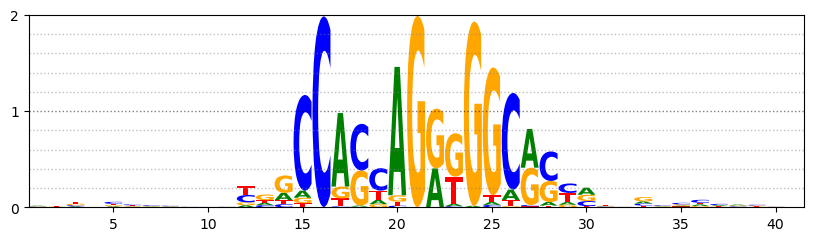

In [46]:
seqs,logopwm,logopssv = get_logos("primates/CTCF_primates.txt",[10,50]);
logopwm.fig

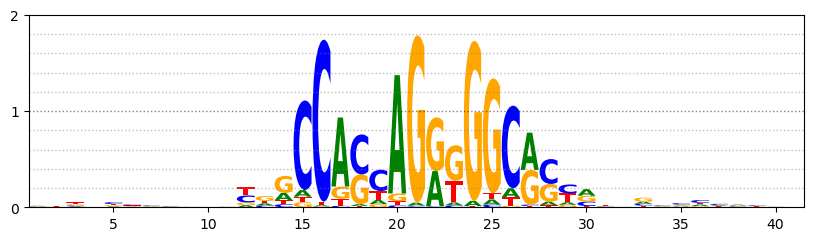

In [47]:
logopssv.fig

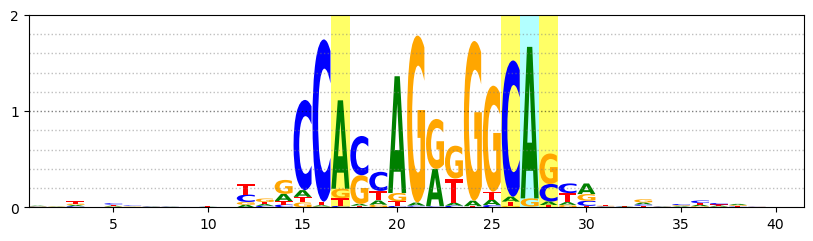

In [48]:
logodiff1,logodiff2 = get_diff_logos(seqs,36,1,3,0.5,[10,50])
logodiff1.highlight_position(26,color="yellow",alpha=0.6)
logodiff1.highlight_position(28,color="yellow",alpha=0.6)
logodiff1.highlight_position(17,color="yellow",alpha=0.6)
logodiff1.fig

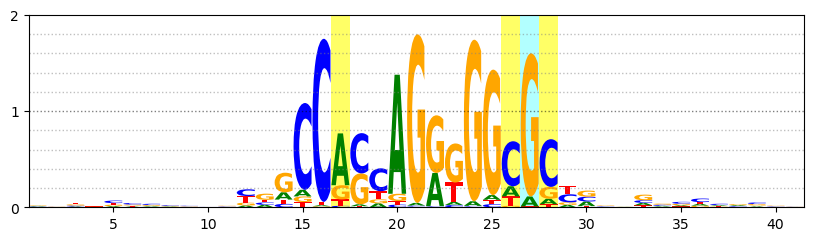

In [49]:
logodiff2.highlight_position(26,color="yellow",alpha=0.6)
logodiff2.highlight_position(28,color="yellow",alpha=0.6)
logodiff2.highlight_position(17,color="yellow",alpha=0.6)
logodiff2.fig

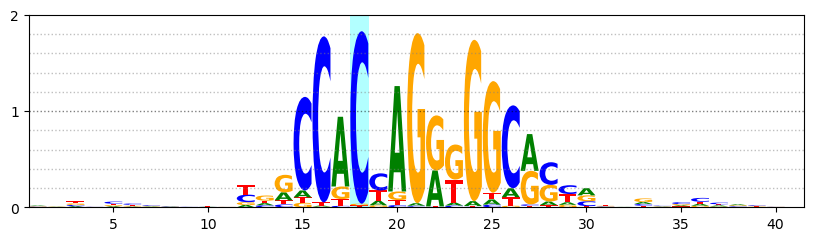

In [50]:
logodiff1,logodiff2 = get_diff_logos(seqs,27,2,3, 0.5, [10,50])
logodiff1.fig

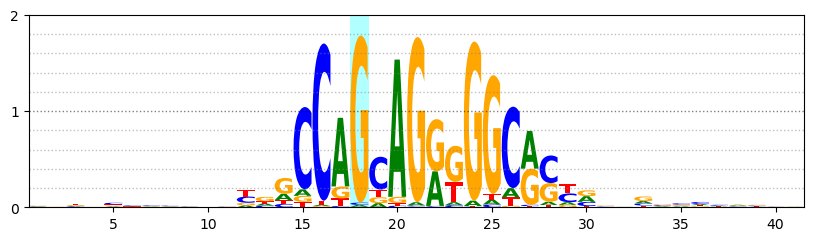

In [51]:
logodiff2.fig

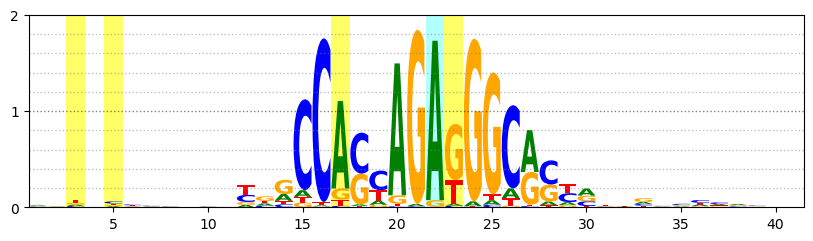

In [52]:
logodiff1,logodiff2 = get_diff_logos(seqs,31,1,3,0.5,[10,50])
logodiff1.highlight_position(17,color="yellow",alpha=0.6)
logodiff1.highlight_position(3,color="yellow",alpha=0.6)
logodiff1.highlight_position(5,color="yellow",alpha=0.6)
logodiff1.highlight_position(23,color="yellow",alpha=0.6)
logodiff1.fig

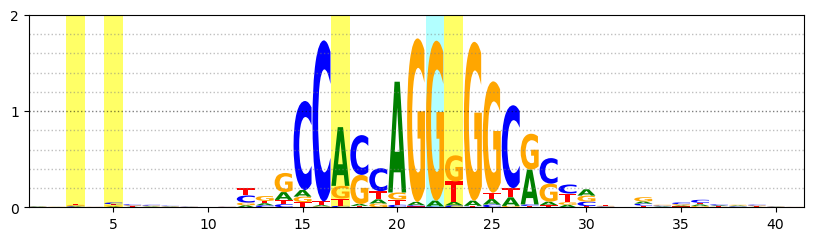

In [53]:
logodiff2.highlight_position(17,color="yellow",alpha=0.6)
logodiff2.highlight_position(3,color="yellow",alpha=0.6)
logodiff2.highlight_position(5,color="yellow",alpha=0.6)
logodiff2.highlight_position(23,color="yellow",alpha=0.6)

logodiff2.fig

#### TCF12 example

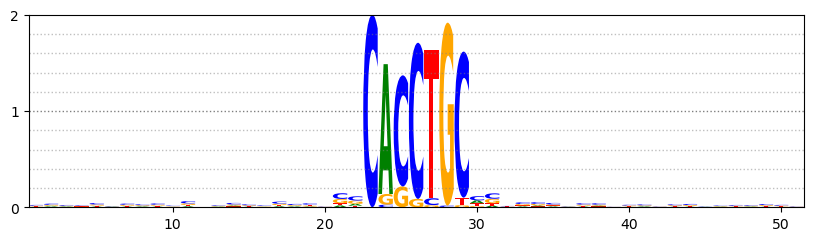

In [54]:
seqs,logopwm,logopssv = get_logos("primates/TCF12_primates.txt")
logopwm.fig

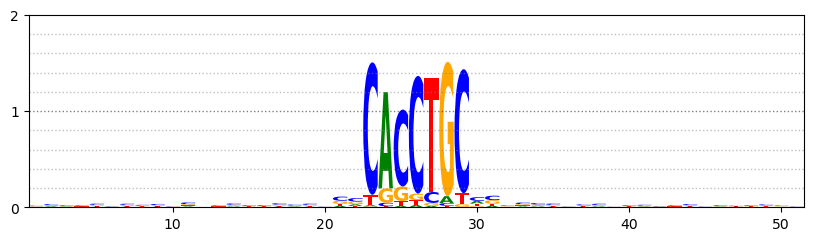

In [55]:
logopssv.fig

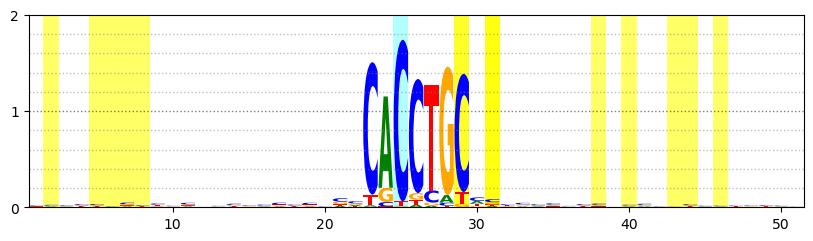

In [56]:
logodiff1,logodiff2 = get_diff_logos(seqs,25,2,3,0.5)
logodiff1.highlight_position(29,color="yellow",alpha=0.6)
logodiff1.highlight_position(31,color="yellow",alpha=0.6)
logodiff1.highlight_position(29,color="yellow",alpha=0.6)
logodiff1.highlight_position(31,color="yellow",alpha=0.6)
logodiff1.highlight_position(31,color="yellow",alpha=0.6)
logodiff1.highlight_position(2,color="yellow",alpha=0.6)

logodiff1.highlight_position(5,color="yellow",alpha=0.6)
logodiff1.highlight_position(6,color="yellow",alpha=0.6)
logodiff1.highlight_position(7,color="yellow",alpha=0.6)
logodiff1.highlight_position(8,color="yellow",alpha=0.6)
logodiff1.highlight_position(38,color="yellow",alpha=0.6)
logodiff1.highlight_position(40,color="yellow",alpha=0.6)
logodiff1.highlight_position(43,color="yellow",alpha=0.6)
logodiff1.highlight_position(44,color="yellow",alpha=0.6)
logodiff1.highlight_position(46,color="yellow",alpha=0.6)
logodiff1.fig

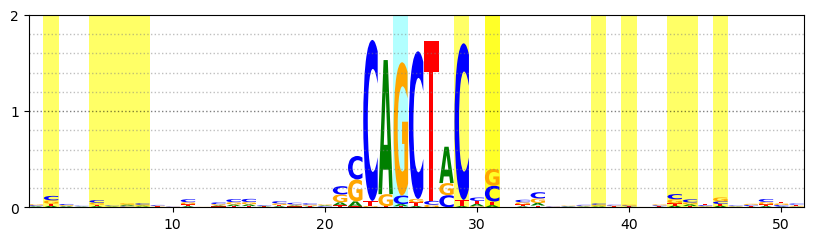

In [57]:
logodiff2.highlight_position(29,color="yellow",alpha=0.6)
logodiff2.highlight_position(31,color="yellow",alpha=0.6)
logodiff2.highlight_position(31,color="yellow",alpha=0.6)
logodiff2.highlight_position(2,color="yellow",alpha=0.6)

logodiff2.highlight_position(5,color="yellow",alpha=0.6)
logodiff2.highlight_position(6,color="yellow",alpha=0.6)
logodiff2.highlight_position(7,color="yellow",alpha=0.6)
logodiff2.highlight_position(8,color="yellow",alpha=0.6)
logodiff2.highlight_position(38,color="yellow",alpha=0.6)
logodiff2.highlight_position(40,color="yellow",alpha=0.6)
logodiff2.highlight_position(43,color="yellow",alpha=0.6)
logodiff2.highlight_position(44,color="yellow",alpha=0.6)
logodiff2.highlight_position(46,color="yellow",alpha=0.6)
logodiff2.fig

In [68]:
##### Try with other factors in "primates" directory
##### For mammals, use "PSSV_mammalss_F81" notebook, or edit tree and recalculate branchlengths above